In [1]:
import matplotlib.pyplot as plt
from numpy.linalg import norm
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.print_version import show_versions
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
show_versions()


INSTALLED VERSIONS
------------------
Python: 3.10.13.final.0
OS: Darwin 23.2.0 Darwin Kernel Version 23.2.0: Wed Nov 15 21:53:18 PST 2023; root:xnu-10002.61.3~2/RELEASE_ARM64_T6000 arm64
byteorder: little
LC_ALL: None
LANG: None

statsmodels

Installed: 0.14.1 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/statsmodels)

Required Dependencies

cython: Not installed
numpy: 1.26.3 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/numpy)
scipy: 1.11.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/scipy)
pandas: 2.1.4 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/pandas)
    dateutil: 2.8.2 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/dateutil)
patsy: 0.5.6 (/opt/homebrew/Caskroom/miniconda/base/envs/sandbox/lib/python3.10/site-packages/patsy)

Optional Dependencies

matplotlib: 3.8.0 (/opt/homebrew/Caskroom/miniconda/ba

In [3]:
def adfuller_test_and_plot(df, first_50=True):
    print(df.describe())

    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    plt.figure(figsize=(30, 8))
    plt.axhline(0, color='k', linestyle='--', alpha=0.2)

    for i in range(0, 50, 7):
        plt.axvline(i, color='k', linestyle='--', alpha=0.2)
    plt.plot(df[:50] if first_50 else df)

           returns
count  1000.000000
mean     -0.000002
std       0.000071
min      -0.000114
25%      -0.000070
50%      -0.000017
75%       0.000069
max       0.000113
ADF Statistic: -29.524358
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


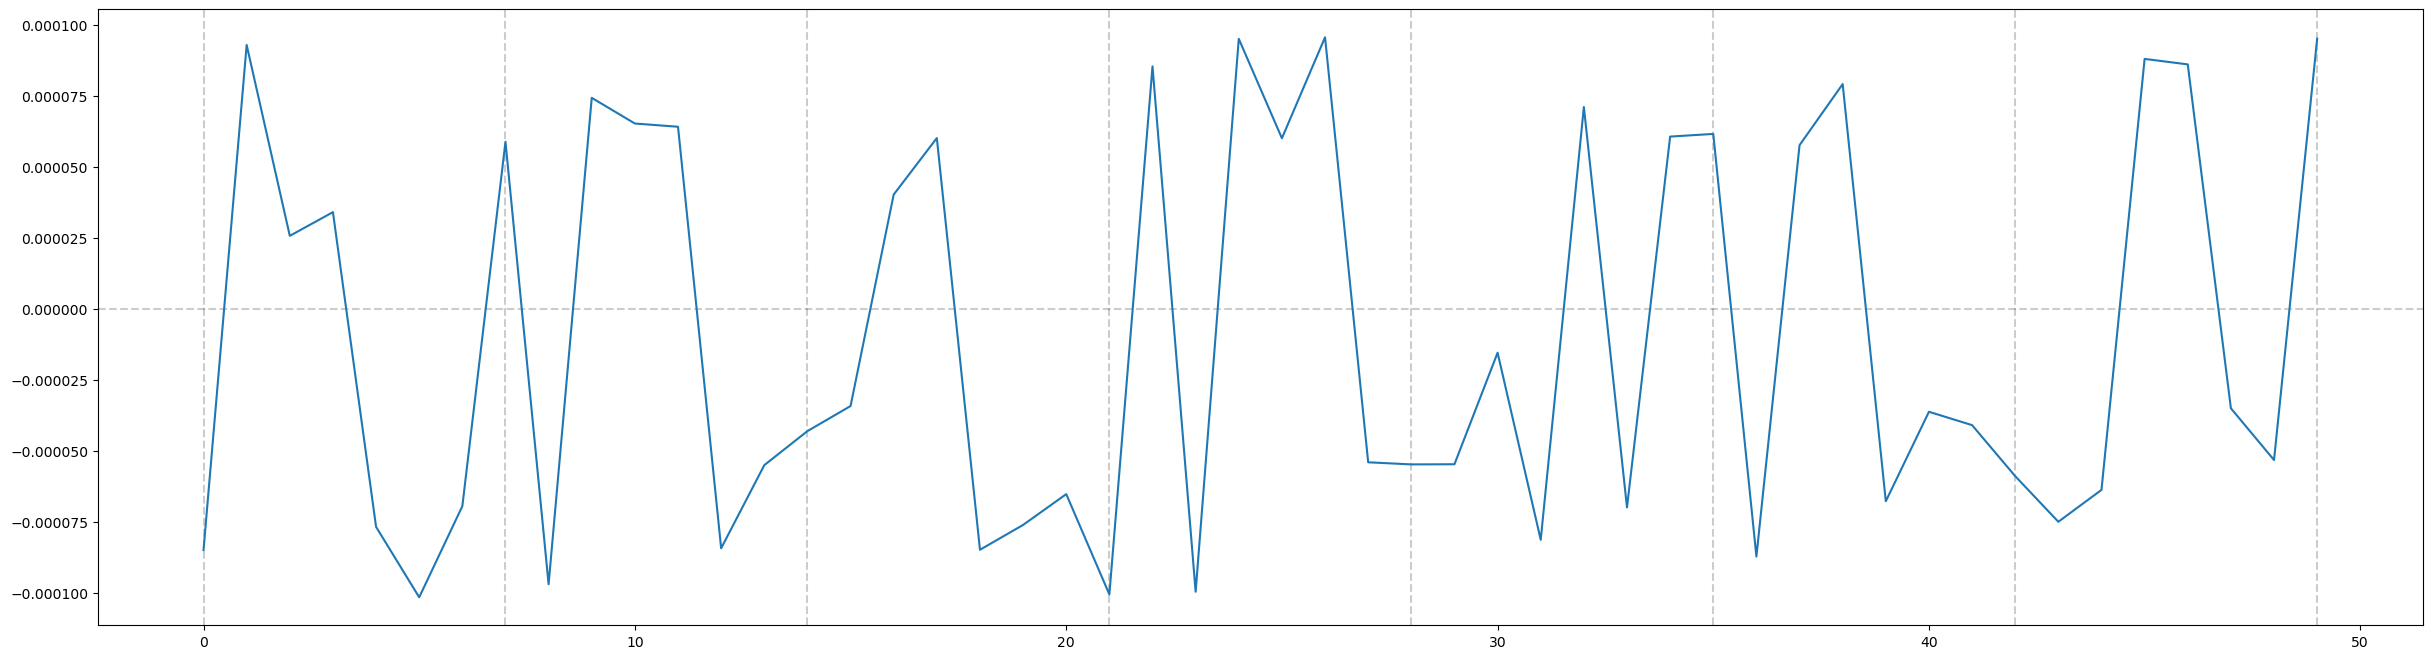

In [4]:
returns = pd.read_csv('returns.txt', header=None)
returns.columns = ['returns']

adfuller_test_and_plot(returns)

            returns
count  1.000000e+03
mean   2.131628e-17
std    1.000000e+00
min   -1.580676e+00
25%   -9.626310e-01
50%   -2.149541e-01
75%    9.997356e-01
max    1.614980e+00
ADF Statistic: -29.524358
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


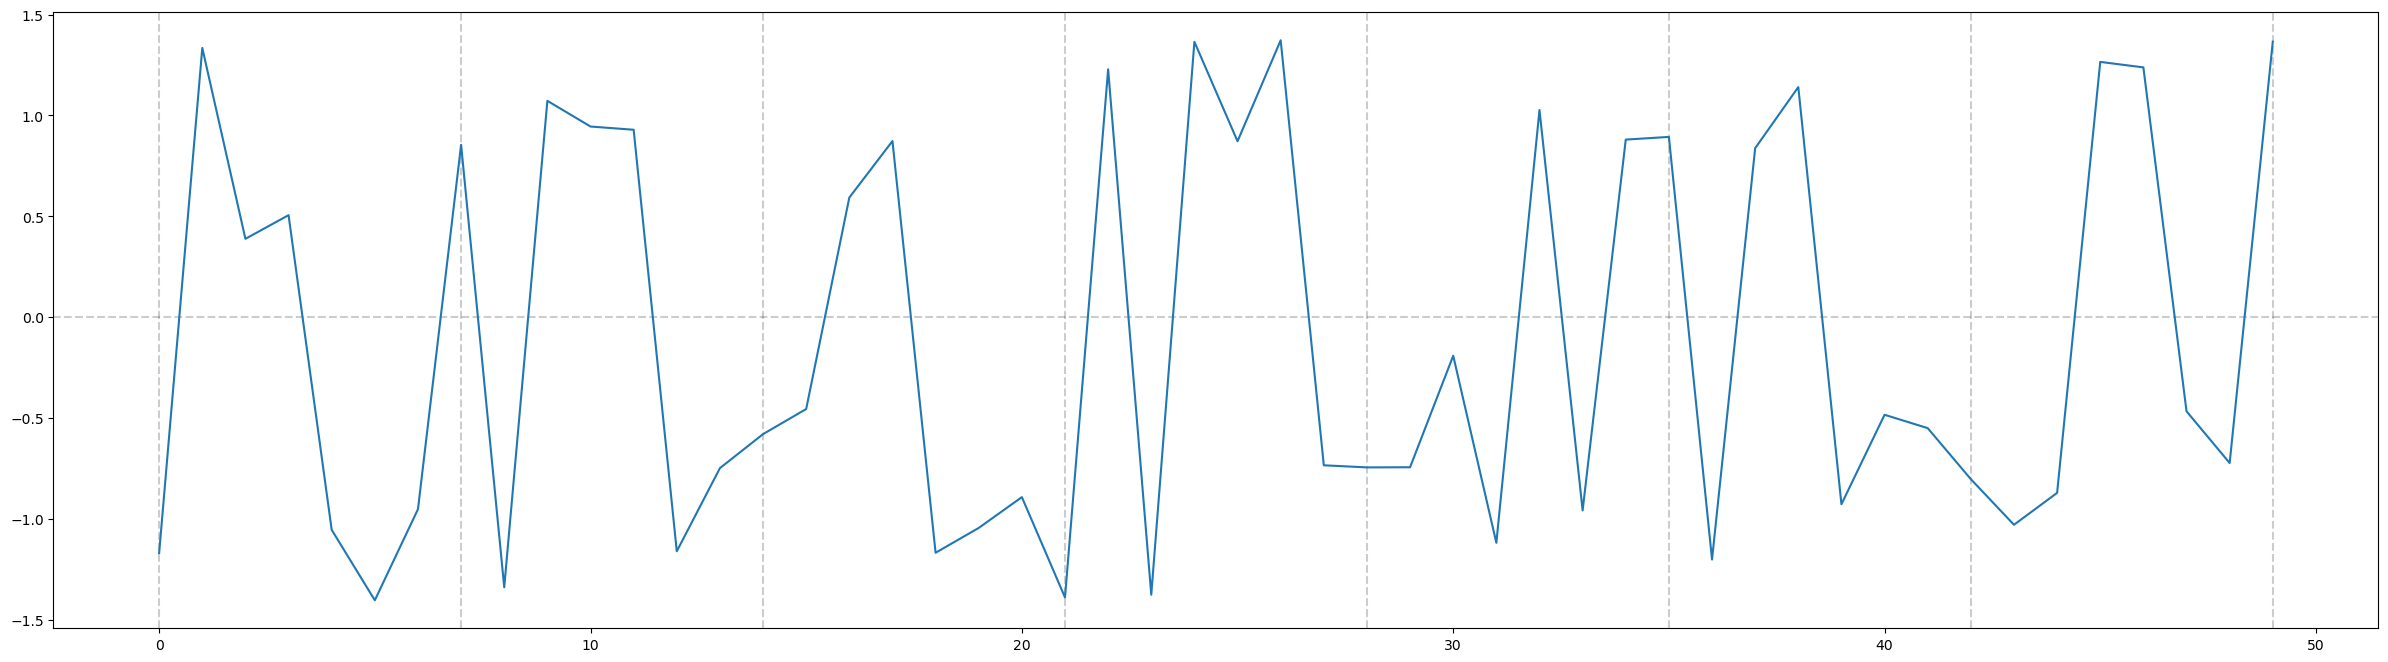

In [5]:
mu = returns.mean()
sigma = returns.std()

norm_returns = (returns - mu) / sigma

adfuller_test_and_plot(norm_returns)

          returns
count  999.000000
mean     0.000321
std      1.365687
min     -2.728297
25%     -0.936848
50%      0.007084
75%      0.888105
max      2.742608
ADF Statistic: -12.117383
p-value: 0.000000
Critical Values:
	1%: -3.437
	5%: -2.865
	10%: -2.568


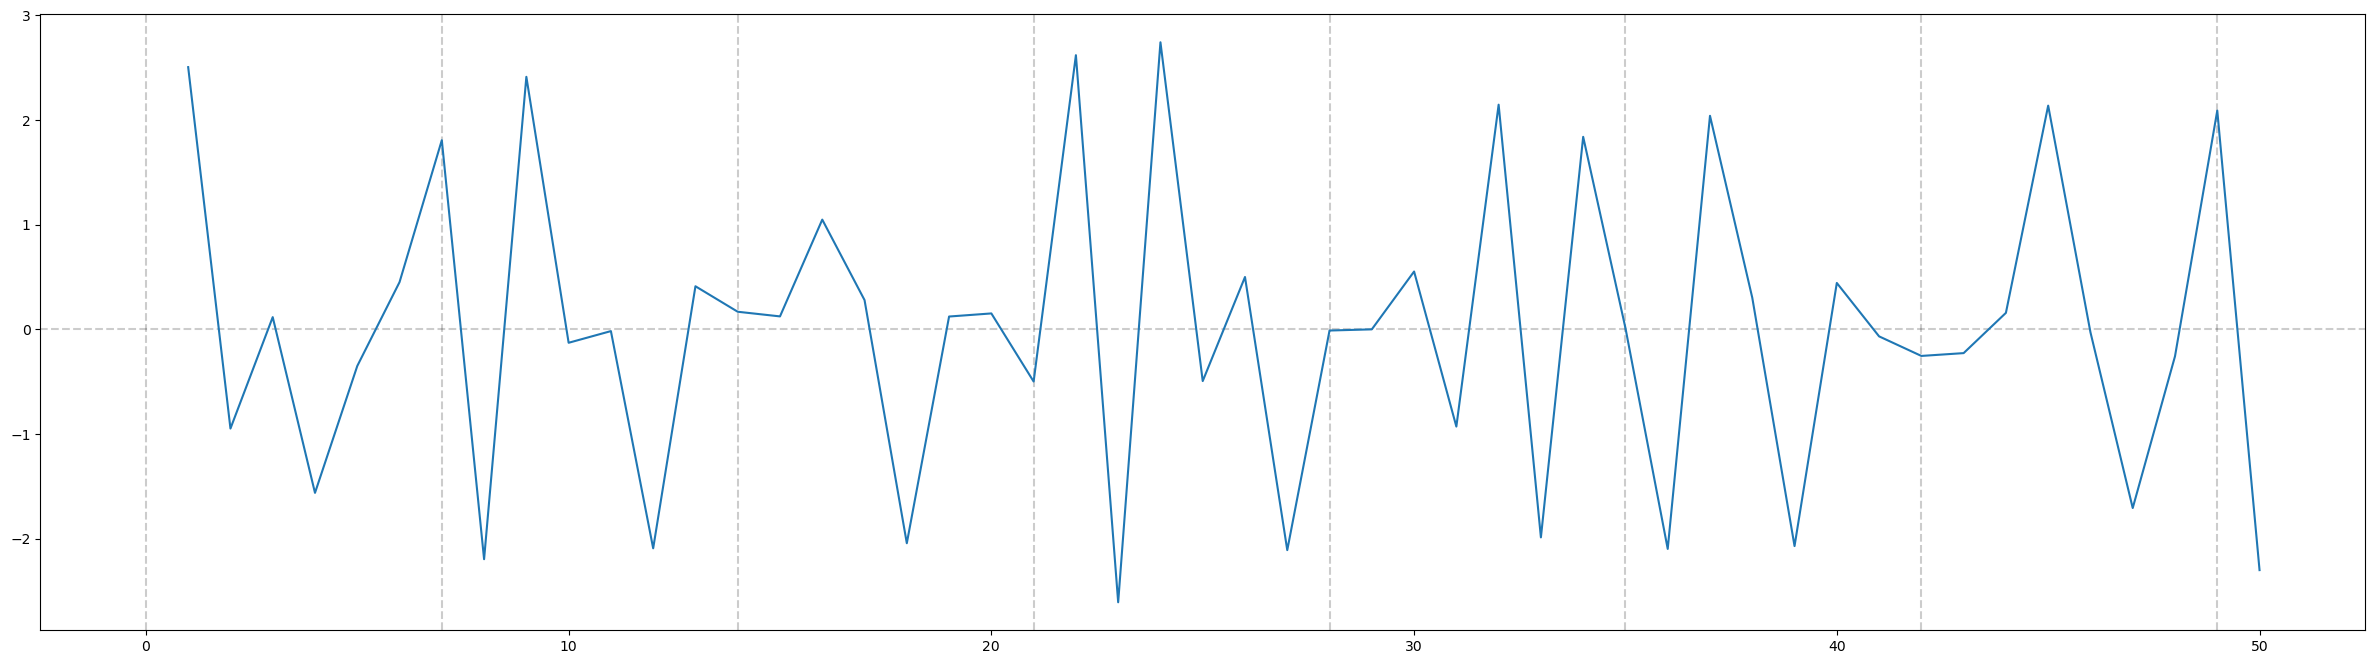

In [6]:
diff_returns = norm_returns.diff().dropna()

adfuller_test_and_plot(diff_returns)

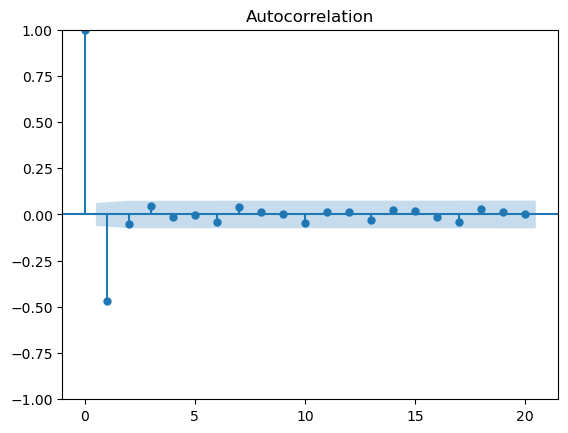

In [7]:
plot_acf(diff_returns, lags=20);

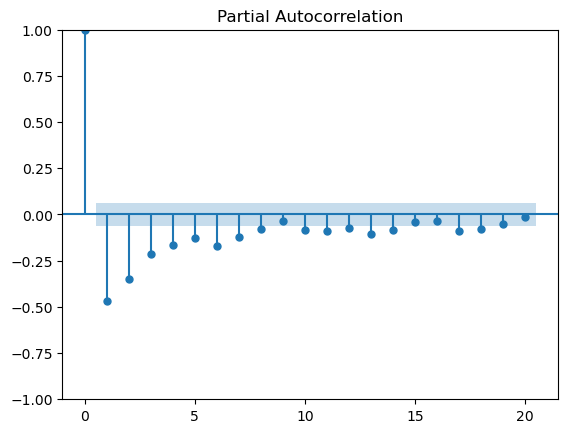

In [8]:
plot_pacf(diff_returns, lags=20);

In [9]:
model = ARIMA(norm_returns, order=(20, 1, 1))
model_fit = model.fit()

In [10]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1000
Model:                ARIMA(20, 1, 1)   Log Likelihood               -1408.580
Date:                Tue, 09 Jan 2024   AIC                           2861.160
Time:                        15:04:35   BIC                           2969.108
Sample:                             0   HQIC                          2902.190
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0569      0.033      1.749      0.080      -0.007       0.121
ar.L2         -0.0018      0.033     -0.056      0.955      -0.066       0.062
ar.L3          0.0428      0.032      1.332      0.183      -0.020       0.106
ar.L4         -0.0182      0.032     -0.563      0.574      -0.081       0.045
ar.L5         -0.0289      0.032     -0.901      0.368      -0.092       0.034
ar.L6         -0.0505      0.033     -1.552      0.121      -0.114       0.013
ar.L7          0.0182      0.032      0.563      0.573      -0.045       0.081
ar.L8         -0.0006      0.033     -0.019      0.985      -0.064       0.063
ar.L9         -0.0337      0.033     -1.029      0.304      -0.098       0.030
ar.L10        -0.0809      0.033     -2.468      0.014      -0.145      -0.017
ar.L11        -0.0368      0.033     -1.128      0.259      -0.101       0.027
ar.L12        -0.0176      0.032     -0.550      0.582      -0.080       0.045
ar.L13        -0.0253      0.032     -0.791      0.429      -0.088       0.037
ar.L14         0.0116      0.033      0.357      0.721      -0.052       0.075
ar.L15         0.0006      0.032      0.018      0.986      -0.063       0.064
ar.L16        -0.0380      0.032     -1.175      0.240      -0.101       0.025
ar.L17        -0.0466      0.032     -1.447      0.148      -0.110       0.017
ar.L18         0.0132      0.032      0.408      0.683      -0.050       0.076
ar.L19         0.0078      0.033      0.238      0.812      -0.057       0.072
ar.L20        -0.0143      0.032     -0.450      0.653      -0.077       0.048
ma.L1         -0.9954      0.005   -204.140      0.000      -1.005      -0.986
sigma2         0.9770      0.101      9.647      0.000       0.779       1.176
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               108.35
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.07
Prob(H) (two-sided):                  0.62   Kurtosis:                         1.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [11]:
{'max': model_fit.params.max(),
 'min': model_fit.params.min(),
 'absolute mean value': norm(model_fit.params, 1) / len(model_fit.params.values)}

{'max': 0.9770464478877356,
 'min': -0.9953845369798886,
 'absolute mean value': 0.11439573478214755}